In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Step 1: Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import torch
from gensim.models import KeyedVectors

# Download NLTK stopwords, punkt, and wordnet resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Step 2: Load the Word2Vec model

In [ ]:
# Load the Word2Vec model
model_path = '/content/drive/MyDrive/Neural Net and Deep Learning Files/GoogleNews-vectors-negative300.bin.gz'
word2vec_model = KeyedVectors.load_word2vec_format(model_path, binary=True)

# Create an embedding matrix for PyTorch
embedding_matrix = torch.FloatTensor(word2vec_model.vectors)

# Load the dataset
file_path = 'train_essays.xlsx'
data = pd.read_excel('/content/drive/MyDrive/Neural Net and Deep Learning Files/train_essays.xlsx')

# Now you can view the data by printing the first few rows
print(data.head())

                                                text  generated
0  Machine learning, a subset of artificial intel...          1
1  A decision tree, a prominent machine learning ...          1
2  Education, a cornerstone of societal progress,...          1
3  Computers, the backbone of modern technology, ...          1
4  Chess, a timeless game of strategy and intelle...          1


In [ ]:
# Preprocessing function to clean and tokenize text
def preprocess_text(text):
    # Convert to lowercase and remove punctuation
    text = text.lower()
    text = re.sub(f'[{string.punctuation}]', '', text)

    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in words]

    return lemmatized

In [ ]:
# Apply preprocessing to each essay
data['processed_text'] = data['text'].apply(preprocess_text)

### Step 3: Vectorize Essays

In [ ]:
# Function to calculate the average vector for an essay
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

# Create a vocabulary from the Word2Vec model
vocabulary = set(word2vec_model.index_to_key)

# Apply the average_word_vectors function to each essay
data['essay_vectors'] = data['processed_text'].apply(
    lambda x: average_word_vectors(x, word2vec_model, vocabulary, 300)
)

# Display the resulting DataFrame with essay vectors
print(data[['text', 'essay_vectors']])

                                                   text  \
0     Machine learning, a subset of artificial intel...   
1     A decision tree, a prominent machine learning ...   
2     Education, a cornerstone of societal progress,...   
3     Computers, the backbone of modern technology, ...   
4     Chess, a timeless game of strategy and intelle...   
...                                                 ...   
1455  There has been a fuss about the Elector Colleg...   
1456  Limiting car usage has many advantages. Such a...   
1457  There's a new trend that has been developing f...   
1458  As we all know cars are a big part of our soci...   
1459  Cars have been around since the 1800's and hav...   

                                          essay_vectors  
0     [0.010999494983303932, 0.021868305821572582, 0...  
1     [0.048919465806749135, 0.027676052517361112, 0...  
2     [-0.029397052267323368, 0.03416144329568614, -...  
3     [0.028334723578559026, -0.02112543015252976, -...  
4

### Step 4: Train the Classifier
With the vectorized essays, you can now train a machine learning classifier:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

In [ ]:
# Assuming you have a target variable 'y' in your dataset
y = data['generated']  # Replace 'target_column' with the actual name of your target column

# Split the data into training and testing sets (70-30 split)
X_train, X_test, y_train, y_test = train_test_split(data['essay_vectors'].tolist(), y, test_size=0.3, random_state=42)

# Convert lists to arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
roc_auc = roc_auc_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC-ROC: {roc_auc}")

Accuracy: 0.997716894977169
Precision: 1.0
Recall: 0.9583333333333334
F1 Score: 0.9787234042553191
AUC-ROC: 0.9791666666666667


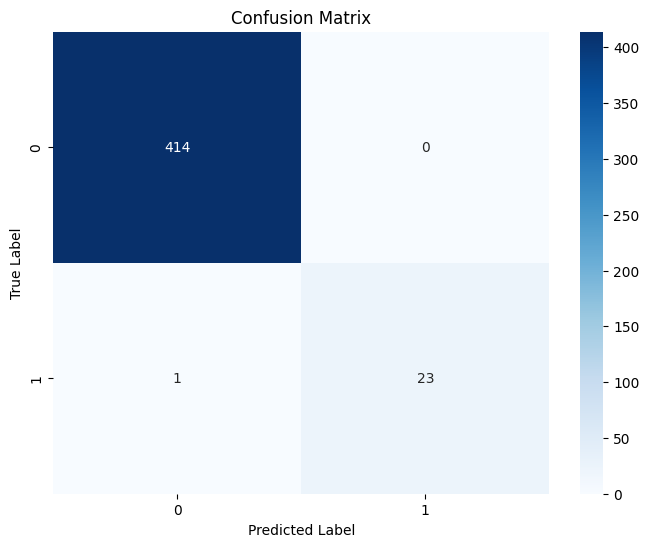

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 0 stand for student essay & 1 stands for LLM essay